# <center>PUBG Game Prediction</center>

<center><img src = "https://media.giphy.com/media/XVbrX433vn6rqkexSj/giphy.gif"></center>

### Table Content

1. [Importing Libraries](#import)
2. [Reading Data](#read)
3. [Data Wrangling](#wrangling)
4. [Feature Engineering](#featureengineering)
5. [ML - CatBoost Model](#catboost)

## Importing Libraries<a class = "anchor" id = "import">

In [24]:
#handling warnings
import warnings
warnings.filterwarnings("ignore")

# Standard libraries
import numpy as np
import pandas as pd

# visualisation
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (16,6)

import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import catboost as cb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

## Reading Data<a class = "anchor" id = "read">

In [25]:
# load the data
df = pd.read_csv("PUBG_Game_Prediction_data.csv")
df.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


In [26]:
# data dimension
df.shape

(4446966, 29)

In [27]:
# data information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               object 
 1   groupId          object 
 2   matchId          object 
 3   assists          int64  
 4   boosts           int64  
 5   damageDealt      float64
 6   DBNOs            int64  
 7   headshotKills    int64  
 8   heals            int64  
 9   killPlace        int64  
 10  killPoints       int64  
 11  kills            int64  
 12  killStreaks      int64  
 13  longestKill      float64
 14  matchDuration    int64  
 15  matchType        object 
 16  maxPlace         int64  
 17  numGroups        int64  
 18  rankPoints       int64  
 19  revives          int64  
 20  rideDistance     float64
 21  roadKills        int64  
 22  swimDistance     float64
 23  teamKills        int64  
 24  vehicleDestroys  int64  
 25  walkDistance     float64
 26  weaponsAcquired  int64  
 27  winPoints   

## Data Wrangling<a class = "anchor" id = "wrangling">

#### Check for the rows with missing win prediction value

In [28]:
# check row with NULL win prediction value
df[df['winPlacePerc'].isnull()]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
2744604,f70c74418bb064,12dfbede33f92b,224a123c53e008,0,0,0.0,0,0,0,1,...,0,0.0,0,0.0,0,0,0.0,0,0,NaN


In [29]:
# remove the data row
df.drop(274604, inplace=True)

#### Understanding Players distribution in a game

In [30]:
# prepare new parameter to know how many players are in a game
df['playersJoined'] = df.groupby('matchId')['matchId'].transform('count')

In [31]:
df.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,playersJoined
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0.0000,0,0.00,0,0,244.80,1,1466,0.4444,96
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0.0045,0,11.04,0,0,1434.00,5,0,0.6400,91
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0.0000,0,0.00,0,0,161.80,2,0,0.7755,98
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0.0000,0,0.00,0,0,202.70,3,0,0.1667,91
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0.0000,0,0.00,0,0,49.75,2,0,0.1875,97


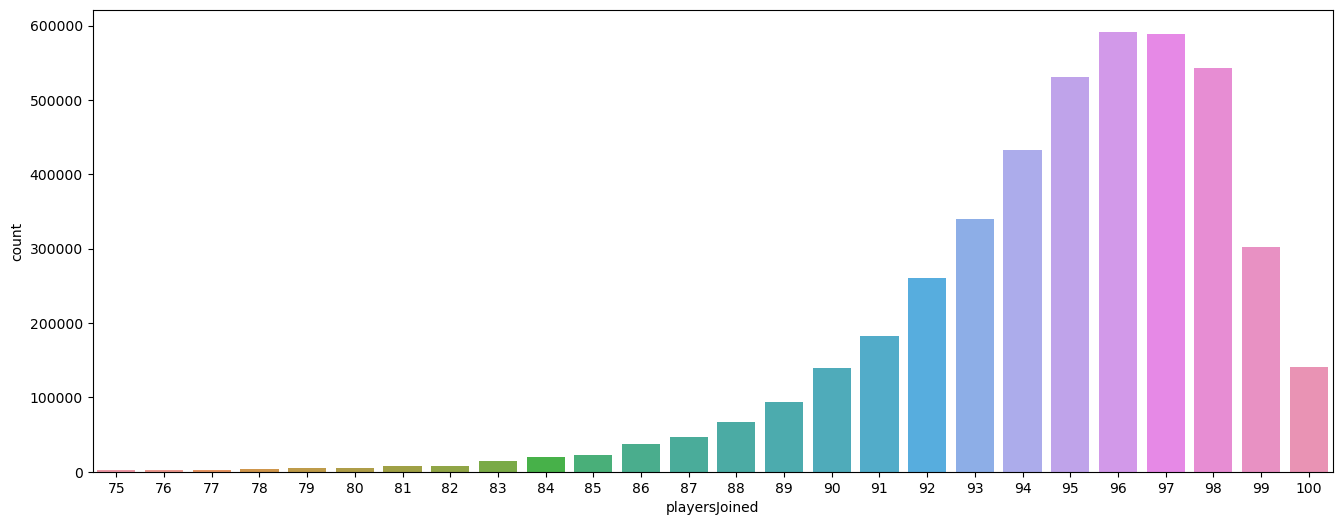

In [32]:
sns.countplot(df[df['playersJoined'] >= 75]['playersJoined'])
plt.show()

#### Analysing the data

##### Kills without moving

In [33]:
# prepare a data parameter to gather the information of the total distance travelled
df['totalDistance'] = df['rideDistance'] + df['walkDistance'] + df['swimDistance']

# prepare a data parameter to check for anamoly detection that the person has not moved but still managed to do the kills
df['killswithoutmoving'] = ((df['kills']>0) & (df['totalDistance'] == 0))

In [34]:
df[df['killswithoutmoving'] == True].head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,playersJoined,totalDistance,killswithoutmoving
1824,b538d514ef2476,0eb2ce2f43f9d6,35e7d750e442e2,0,0,593.0,0,0,3,18,...,0.0,0,0,0.0,8,0,0.8571,58,0.0,True
6673,6d3a61da07b7cb,2d8119b1544f87,904cecf36217df,2,0,346.6,0,0,6,33,...,0.0,0,0,0.0,22,0,0.6000,42,0.0,True
11892,550398a8f33db7,c3fd0e2abab0af,db6f6d1f0d4904,2,0,1750.0,0,4,5,3,...,0.0,0,0,0.0,13,0,0.8947,21,0.0,True
14631,58d690ee461e9d,ea5b6630b33d67,dbf34301df5e53,0,0,157.8,0,0,0,69,...,0.0,0,0,0.0,7,1500,0.0000,73,0.0,True
15591,49b61fc963d632,0f5c5f19d9cc21,904cecf36217df,0,0,100.0,0,1,0,37,...,0.0,0,0,0.0,10,0,0.3000,42,0.0,True


In [36]:
df[df['killswithoutmoving'] == True].shape

(1535, 32)

In [37]:
# drop the table
df.drop(df[df['killswithoutmoving'] == True].index, inplace=True)

##### Extra-ordinary Road Kills

In [38]:
df[df['roadKills'] > 5].shape

(46, 32)

In [39]:
df.drop(df[df['roadKills'] > 5].index, inplace=True)

##### So many kills - How???

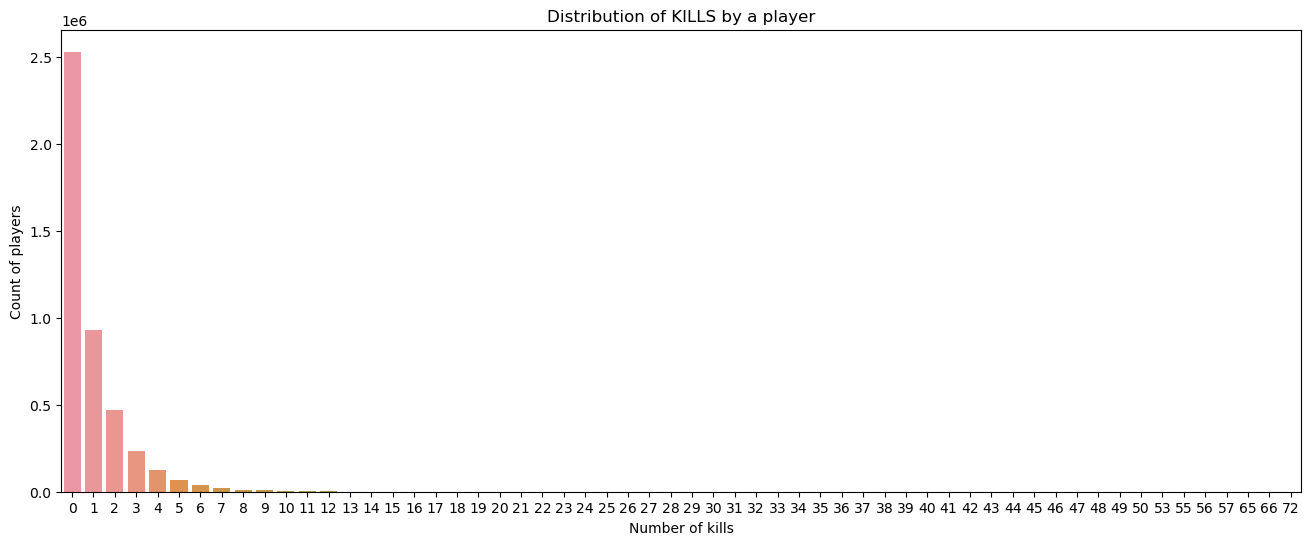

In [42]:
sns.countplot(data = df, x = df['kills']).set_title("Distribution of KILLS by a player")
plt.ylabel("Count of players")
plt.xlabel("Number of kills")
plt.show()

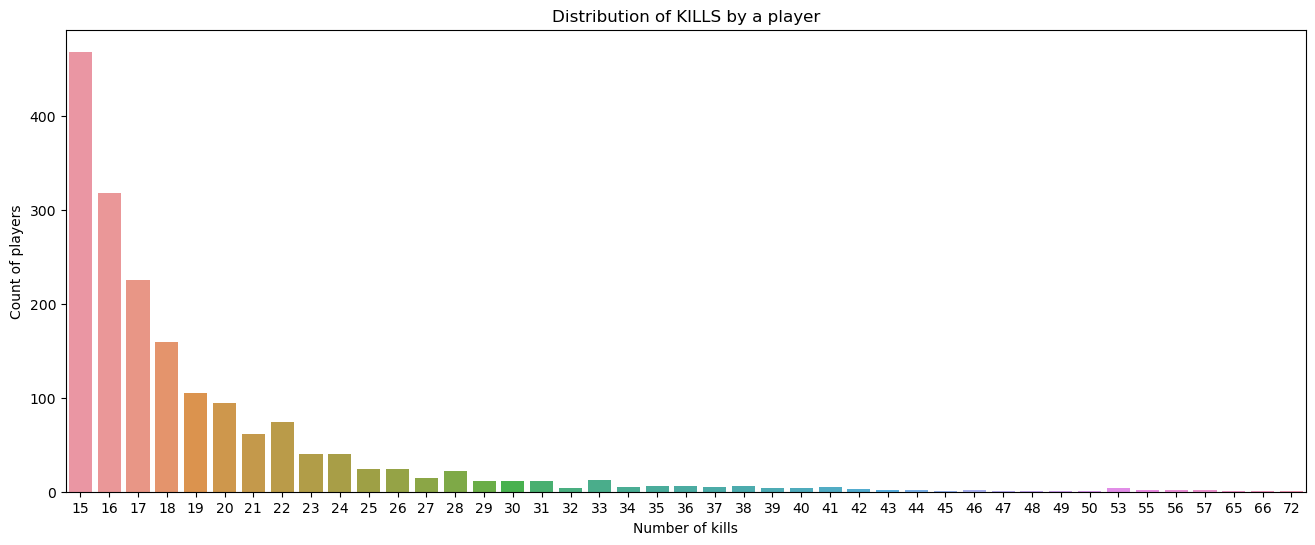

In [43]:
sns.countplot(df[df['kills']>=15]['kills']).set_title("Distribution of KILLS by a player")
plt.ylabel("Count of players")
plt.xlabel("Number of kills")
plt.show()

In [44]:
# data dimension
df[df['kills']>20].shape

(417, 32)

In [45]:
# drop the instances
df.drop(df[df['kills']>20].index, inplace=True)

##### Head Shot

In [46]:
df['headshot_rate'] = df['headshotKills']/df['kills']
df['headshot_rate'] = df['headshot_rate'].fillna(0)

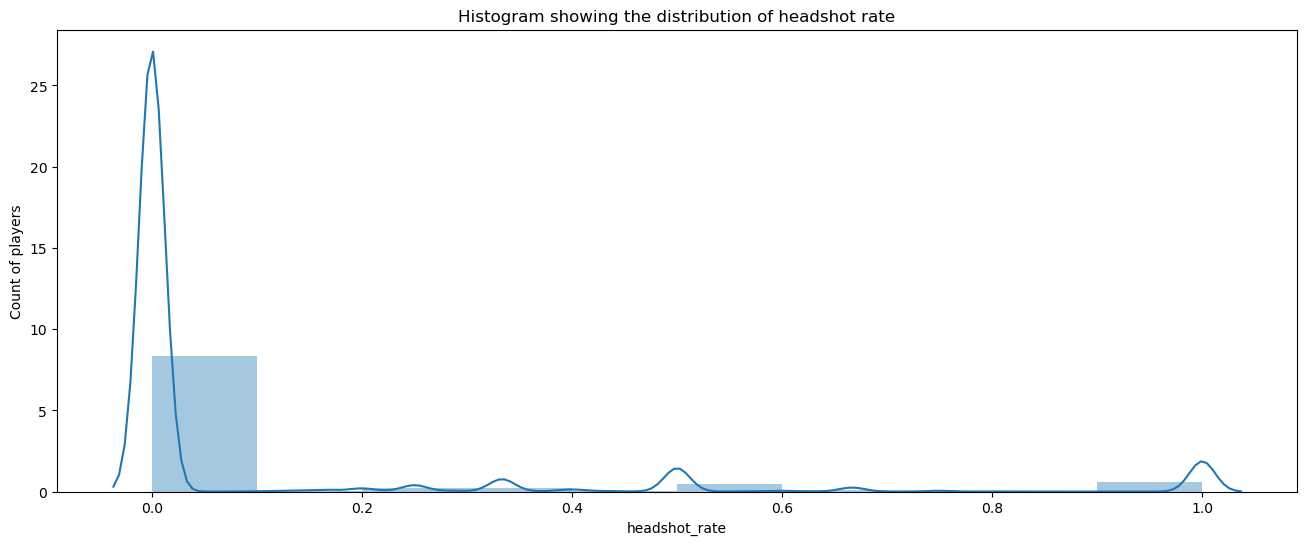

In [47]:
# plot the headshot rate distribution
sns.distplot(df['headshot_rate'], bins = 10).set_title("Histogram showing the distribution of headshot rate")
plt.ylabel("Count of players")
plt.show()

In [48]:
df[(df['headshot_rate'] == 1) & (df['kills']>5)].shape

(187, 33)

In [49]:
df.drop(df[(df['headshot_rate'] == 1) & (df['kills'] >6)].index, inplace = True)

##### Longest Shot

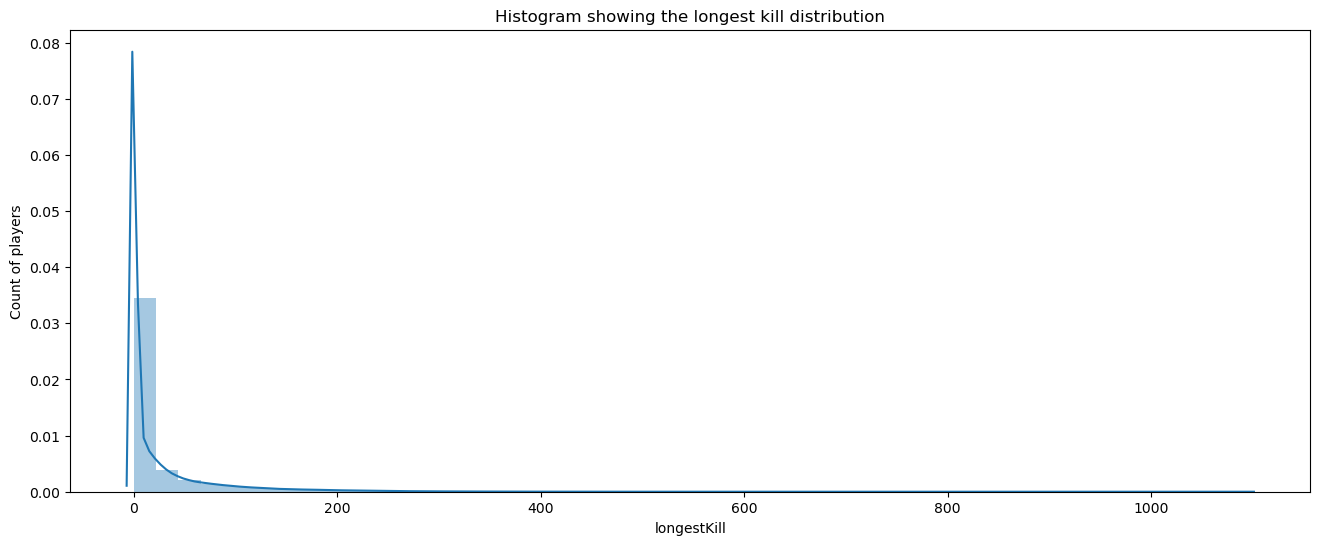

In [50]:
sns.distplot(df['longestKill'], bins = 50).set_title("Histogram showing the longest kill distribution")
plt.ylabel("Count of players")
plt.show()

In [51]:
df[df['longestKill'] >= 500].shape

(1747, 33)

In [52]:
df.drop(df[df['longestKill'] >= 500].index, inplace = True)

##### Weapon Change

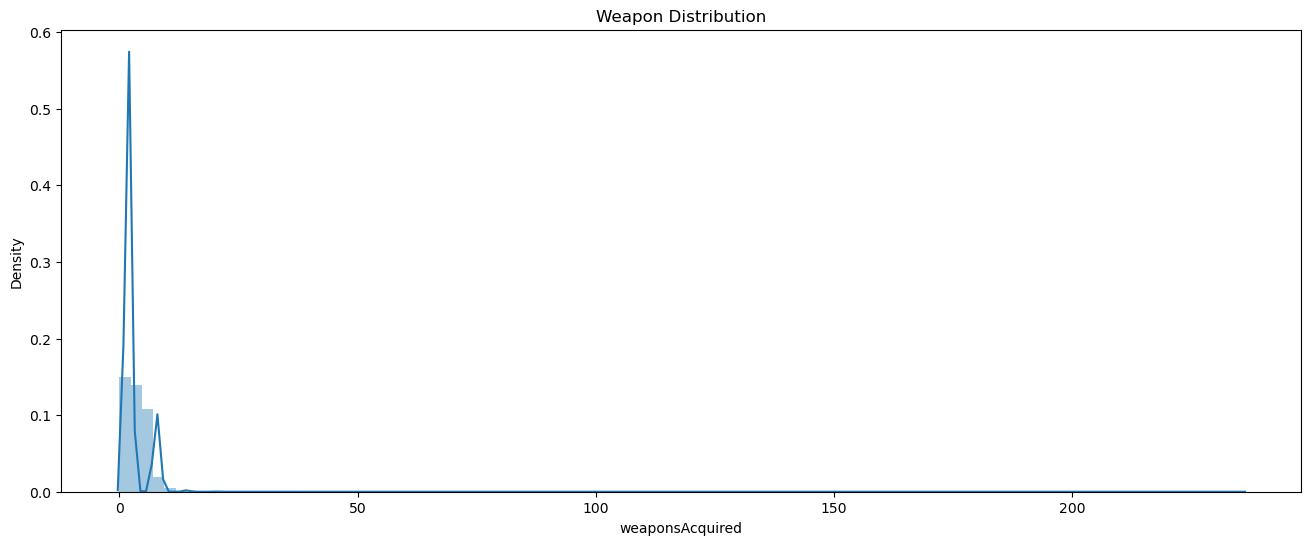

In [53]:
sns.distplot(df['weaponsAcquired'], bins = 100).set_title("Weapon Distribution")
plt.show()

In [54]:
df[df['weaponsAcquired'] >= 15].shape

(6809, 33)

In [55]:
df.drop(df[df['weaponsAcquired'] >= 15].index, inplace=True)

#### Exploratory Data Analysis

In [56]:
df.shape

(4436306, 33)

In [57]:
df.isna().sum()

Id                    0
groupId               0
matchId               0
assists               0
boosts                0
damageDealt           0
DBNOs                 0
headshotKills         0
heals                 0
killPlace             0
killPoints            0
kills                 0
killStreaks           0
longestKill           0
matchDuration         0
matchType             0
maxPlace              0
numGroups             0
rankPoints            0
revives               0
rideDistance          0
roadKills             0
swimDistance          0
teamKills             0
vehicleDestroys       0
walkDistance          0
weaponsAcquired       0
winPoints             0
winPlacePerc          1
playersJoined         0
totalDistance         0
killswithoutmoving    0
headshot_rate         0
dtype: int64

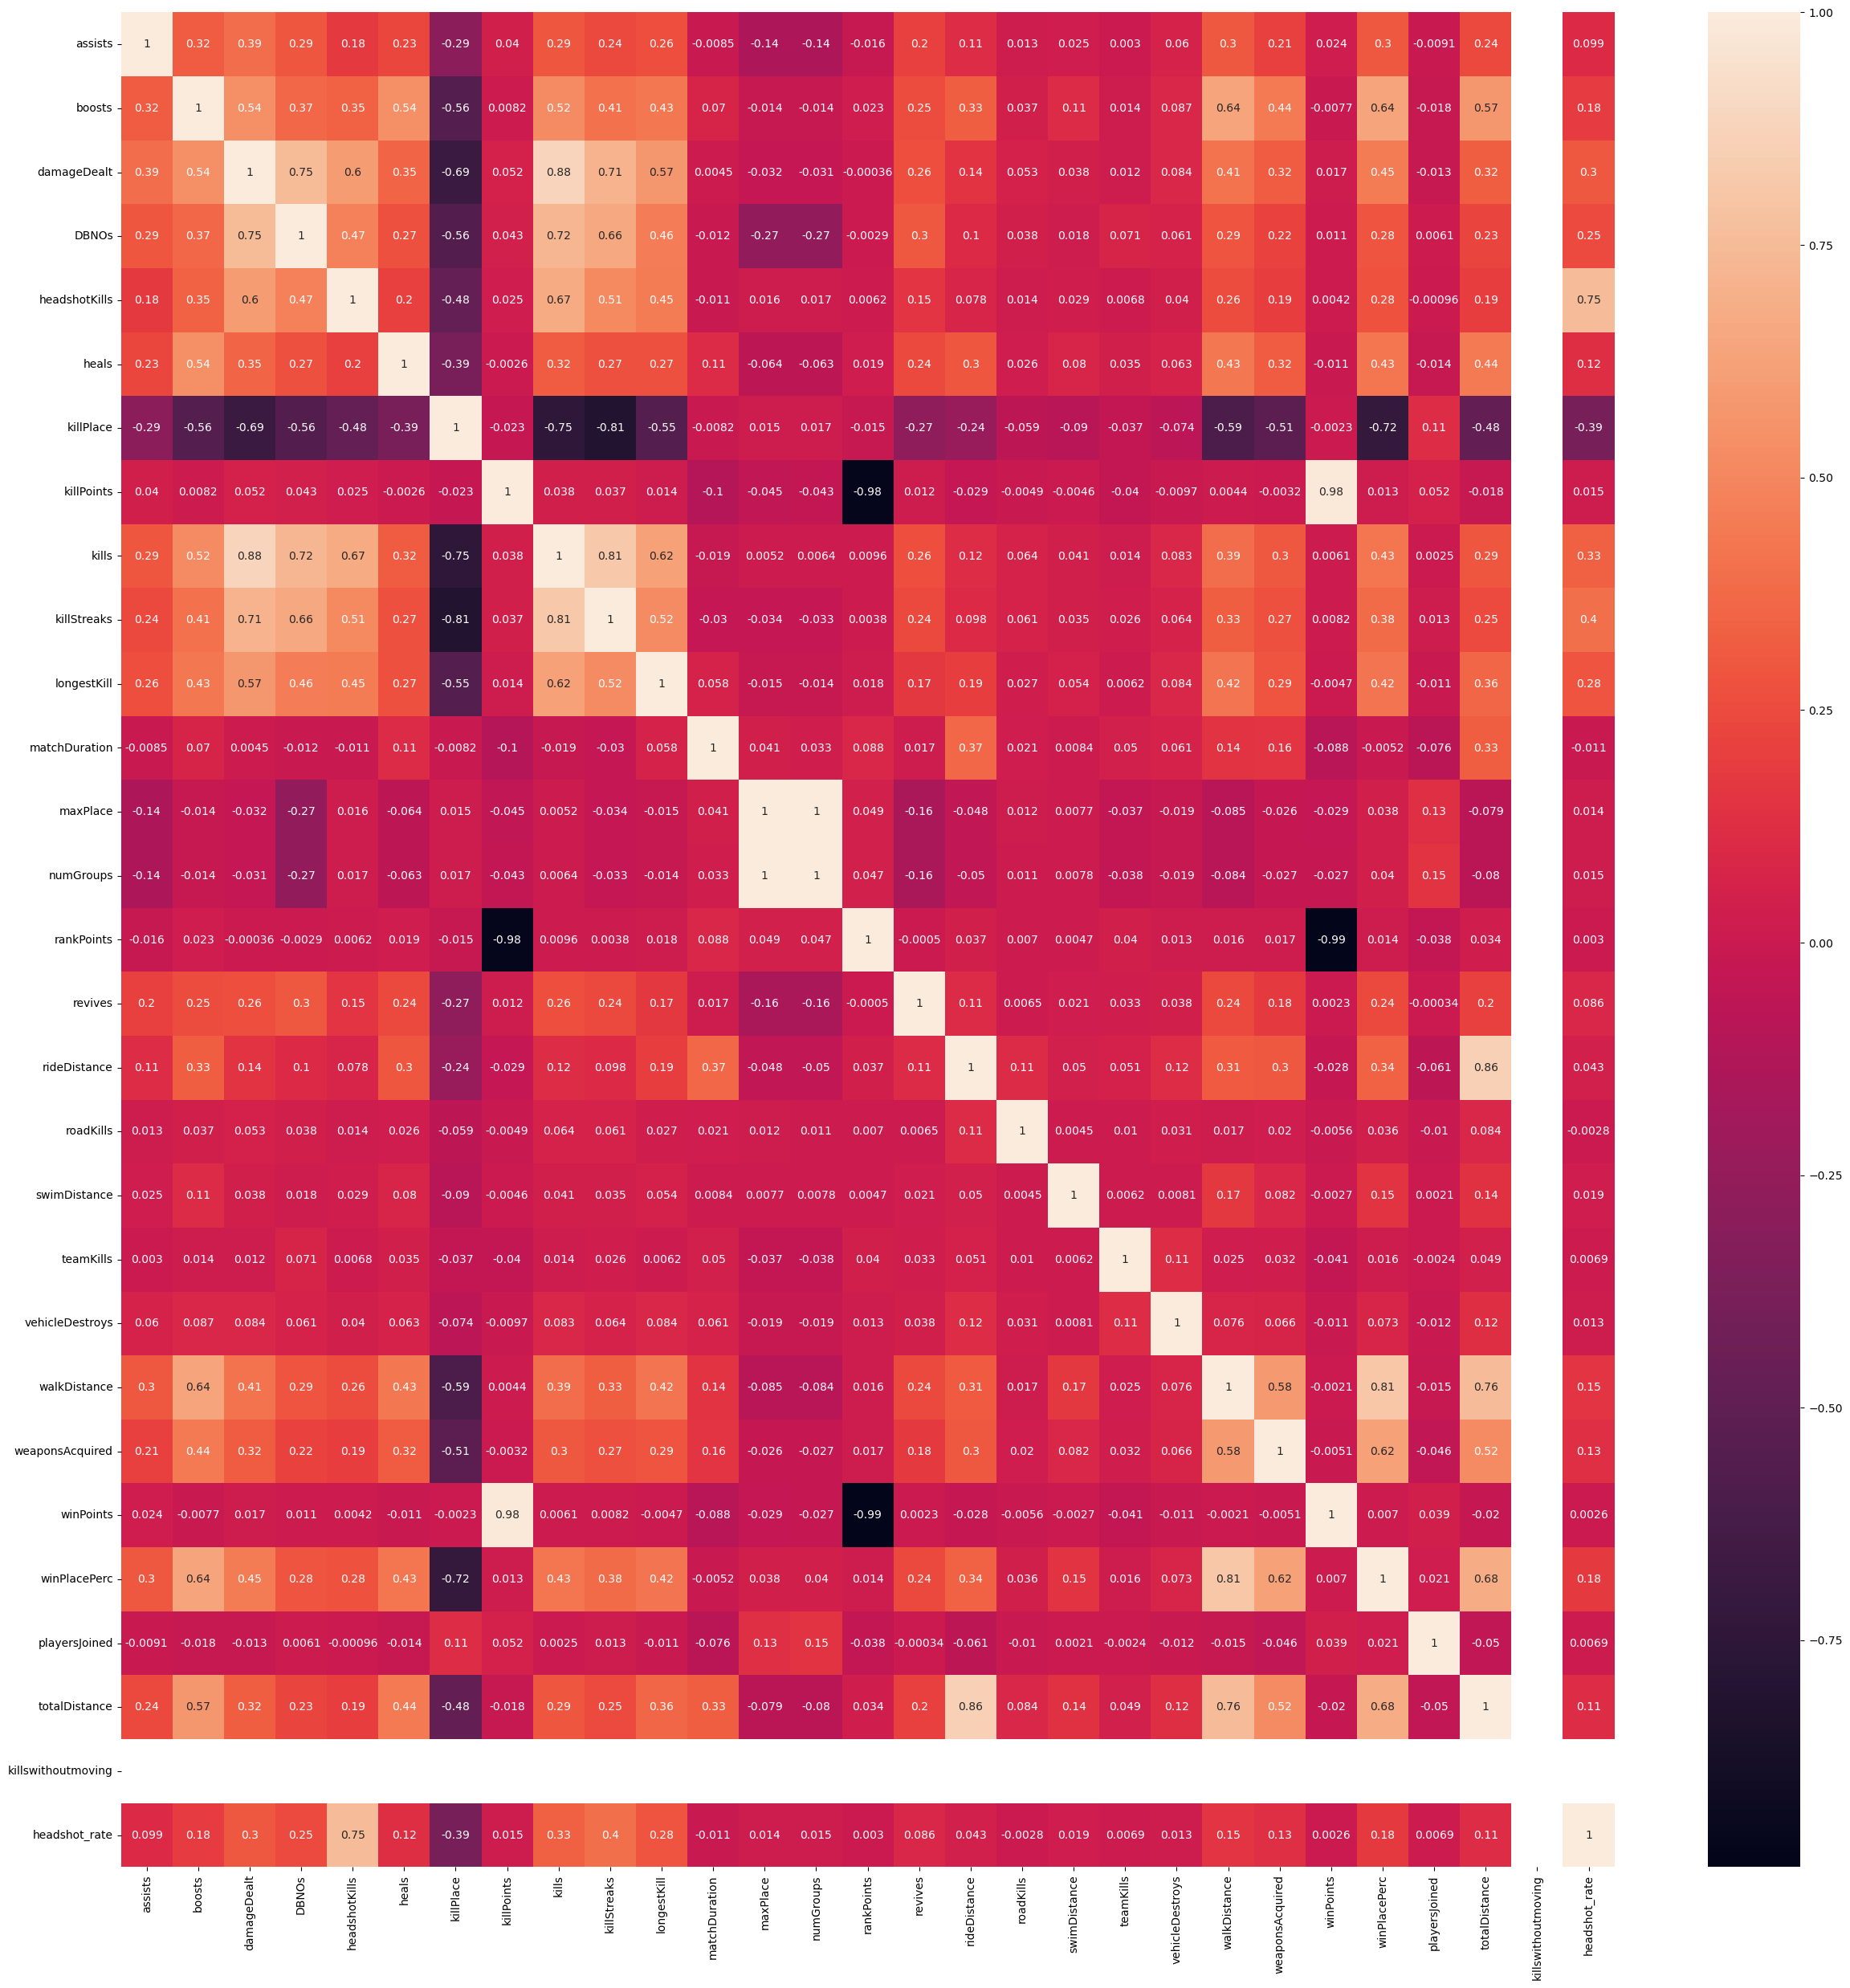

In [58]:
# correlation of parameter with win prediction
plt.figure(figsize=[30,30])
sns.heatmap(df.corr(), annot = True)
plt.show()

## Feature Engineering<a class = "anchor" id = "featureengineering">

In [59]:
normalising_factor = (100 - df['playersJoined']/100) + 1

In [61]:
df['killsNorm'] = df['kills'] * normalising_factor
df['damageDealtNorm'] = df['damageDealt']*normalising_factor
df['maxPlaceNorm'] = df['maxPlace']*normalising_factor
df['matchDurationNorm'] = df['matchDuration']*normalising_factor

df['traveldistance'] = df['walkDistance'] + df['swimDistance'] + df['rideDistance']
df['healsnboosts'] = df['heals'] + df['boosts']
df['assist'] = df['assists'] + df['revives']

In [62]:
df.columns

Index(['Id', 'groupId', 'matchId', 'assists', 'boosts', 'damageDealt', 'DBNOs',
       'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills',
       'killStreaks', 'longestKill', 'matchDuration', 'matchType', 'maxPlace',
       'numGroups', 'rankPoints', 'revives', 'rideDistance', 'roadKills',
       'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance',
       'weaponsAcquired', 'winPoints', 'winPlacePerc', 'playersJoined',
       'totalDistance', 'killswithoutmoving', 'headshot_rate', 'killsNorm',
       'damageDealtNorm', 'maxPlaceNorm', 'matchDurationNorm',
       'traveldistance', 'healsnboosts', 'assist'],
      dtype='object')

In [63]:
data = df.drop(columns = ['Id','groupId','matchId','assists','boosts','walkDistance','swimDistance','rideDistance','heals','revives','kills',
                          'damageDealt','maxPlace','matchDuration'])

In [64]:
data.head()

,DBNOs,headshotKills,killPlace,killPoints,killStreaks,longestKill,matchType,numGroups,rankPoints,roadKills,...,totalDistance,killswithoutmoving,headshot_rate,killsNorm,damageDealtNorm,maxPlaceNorm,matchDurationNorm,traveldistance,healsnboosts,assist
0,0,0,60,1241,0,0.00,squad-fpp,26,-1,0,...,244.8000,False,0.0,0.00,0.0000,2801.12,130652.24,244.8000,0,0
1,0,0,57,0,0,0.00,squad-fpp,25,1484,0,...,1445.0445,False,0.0,0.00,9155.2323,2602.34,177859.93,1445.0445,0,0
2,0,0,47,0,0,0.00,duo,47,1491,0,...,161.8000,False,0.0,0.00,6801.3600,5001.00,131826.36,161.8000,0,1
3,0,0,75,0,0,0.00,squad-fpp,30,1408,0,...,202.7000,False,0.0,0.00,3292.9610,3102.79,143729.24,202.7000,0,0
4,0,0,45,0,1,58.53,solo-fpp,95,1560,0,...,49.7500,False,0.0,100.03,10003.0000,9702.91,142442.72,49.7500,0,0


## ML - Catboost Model<a class = "anchor" id = "catboost">

### Handling Categorical Data

In [65]:
x = df.drop(['winPlacePerc'], axis = 1)
y = data['winPlacePerc']

In [67]:
features  = x.columns
features

Index(['Id', 'groupId', 'matchId', 'assists', 'boosts', 'damageDealt', 'DBNOs',
       'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills',
       'killStreaks', 'longestKill', 'matchDuration', 'matchType', 'maxPlace',
       'numGroups', 'rankPoints', 'revives', 'rideDistance', 'roadKills',
       'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance',
       'weaponsAcquired', 'winPoints', 'playersJoined', 'totalDistance',
       'killswithoutmoving', 'headshot_rate', 'killsNorm', 'damageDealtNorm',
       'maxPlaceNorm', 'matchDurationNorm', 'traveldistance', 'healsnboosts',
       'assist'],
      dtype='object')

In [70]:
x = pd.get_dummies(x, columns = ['matchType', 'killswithoutmoving'])

In [71]:
x.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,matchType_normal-duo-fpp,matchType_normal-solo,matchType_normal-solo-fpp,matchType_normal-squad,matchType_normal-squad-fpp,matchType_solo,matchType_solo-fpp,matchType_squad,matchType_squad-fpp,killswithoutmoving_False
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0,0,0,0,0,0,0,1,1
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,0,0,0,0,0,0,0,1,1
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0,0,0,0,0,0,0,0,0,1
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0,0,0,0,0,0,0,0,1,1
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0,0,0,0,0,0,1,0,0,1


In [72]:
x.shape

(4436306, 54)

#### Scaling the data

In [168]:
sc = StandardScaler()
sc.fit(x)
x = pd.DataFrame(sc.transform(x))

In [169]:
x.head()

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,-0.582937,-0.384018,0.449345,1.172485,-0.765100,-0.459622,-0.732886,-1.212390,-0.049567,-0.142509,...,-0.033604,-0.005244,-0.013803,-0.008292,-0.054367,-0.206514,-0.370797,-0.405071,1.236192,0.0
1,-0.582937,-0.384018,0.340055,-0.804728,-0.765100,-0.459622,-0.775859,0.803564,-0.049567,-0.142509,...,-0.033604,-0.005244,-0.013803,-0.008292,-0.054367,-0.206514,-0.370797,-0.405071,1.236192,0.0
2,-0.582937,-0.384018,-0.024245,-0.804728,-0.765100,-0.459622,0.169557,0.813067,-0.049567,-0.142509,...,-0.033604,-0.005244,-0.013803,-0.008292,-0.054367,-0.206514,-0.370797,-0.405071,-0.808936,0.0
3,-0.582937,-0.384018,0.995795,-0.804728,-0.765100,-0.459622,-0.560992,0.700391,-0.049567,-0.142509,...,-0.033604,-0.005244,-0.013803,-0.008292,-0.054367,-0.206514,-0.370797,-0.405071,1.236192,0.0
4,-0.582937,-0.384018,-0.097105,-0.804728,0.647633,0.727371,2.232284,0.906738,-0.049567,-0.142509,...,-0.033604,-0.005244,-0.013803,-0.008292,-0.054367,-0.206514,2.696896,-0.405071,-0.808936,0.0


### Splitting the Data

In [170]:
xtrain, xtest, ytrain, ytest= train_test_split(x, y, test_size = 0.3, random_state = 0)

In [171]:
print(xtrain.shape, ytrain.shape)
print(xtest.shape, ytest.shape)

(3105414, 40) (3105414,)
(1330892, 40) (1330892,)


## Catboost Model

In [172]:
import catboost as cb

In [173]:
train_dataset = cb.Pool(xtrain, ytrain)
test_dataset = cb.Pool(xtest, ytest)

In [174]:
model = cb.CatBoostRegressor(loss_function='RMSE')

In [180]:
# GRID Search

grid = {'iterations': [100, 150], 
       'learning_rate': [0.03, 0.1], 
       'depth': [2, 4, 6, 8]}

model.grid_search(grid, train_dataset)

0:	learn: 0.5482016	test: 0.5479886	best: 0.5479886 (0)	total: 347ms	remaining: 34.4s
1:	learn: 0.5333650	test: 0.5331566	best: 0.5331566 (1)	total: 702ms	remaining: 34.4s
2:	learn: 0.5189826	test: 0.5187815	best: 0.5187815 (2)	total: 1.05s	remaining: 34s
3:	learn: 0.5050844	test: 0.5048926	best: 0.5048926 (3)	total: 1.35s	remaining: 32.4s
4:	learn: 0.4916276	test: 0.4914432	best: 0.4914432 (4)	total: 1.84s	remaining: 35.1s
5:	learn: 0.4786251	test: 0.4784449	best: 0.4784449 (5)	total: 2.51s	remaining: 39.4s
6:	learn: 0.4660267	test: 0.4658539	best: 0.4658539 (6)	total: 3.24s	remaining: 43.1s
7:	learn: 0.4538495	test: 0.4536820	best: 0.4536820 (7)	total: 3.95s	remaining: 45.4s
8:	learn: 0.4420341	test: 0.4418693	best: 0.4418693 (8)	total: 4.32s	remaining: 43.7s
9:	learn: 0.4306331	test: 0.4304748	best: 0.4304748 (9)	total: 4.63s	remaining: 41.6s
10:	learn: 0.4195967	test: 0.4194453	best: 0.4194453 (10)	total: 4.96s	remaining: 40.1s
11:	learn: 0.4089243	test: 0.4087765	best: 0.4087765 (

{'params': {'depth': 8, 'iterations': 150, 'learning_rate': 0.1},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
    

In [181]:
feature_importance_df = pd.DataFrame()
feature_importance_df['features'] = features
feature_importance_df['importance'] = model.feature_importances_

feature_importance_df = feature_importance_df.sort_values(by = ['importance'], ascending=False)

In [182]:
feature_importance_df

,features,importance
2,killPlace,40.804634
14,totalDistance,12.507865
20,traveldistance,11.786296
16,killsNorm,7.596194
4,killStreaks,7.568429
19,matchDurationNorm,5.355363
13,playersJoined,4.684276
6,numGroups,2.265490
21,healsnboosts,1.830046
5,longestKill,1.805096


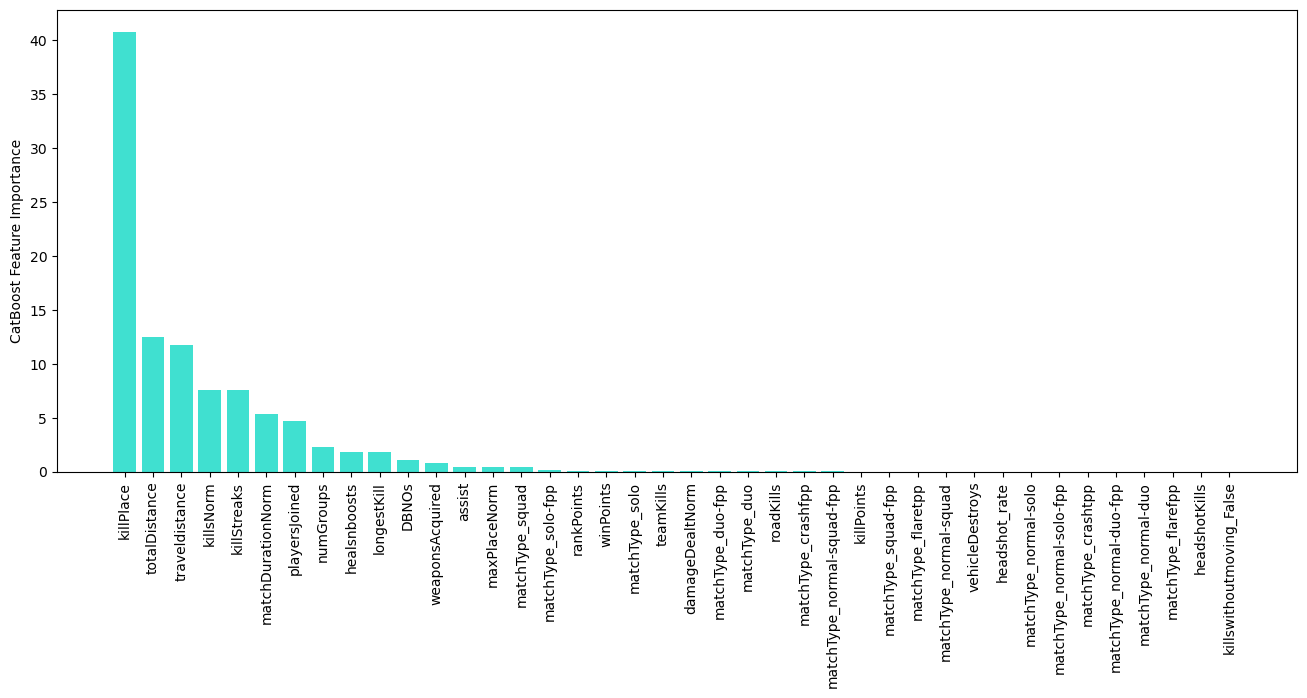

In [183]:
plt.bar(feature_importance_df.features, feature_importance_df.importance, color='turquoise')
plt.ylabel("CatBoost Feature Importance")
plt.xticks(rotation = 90)
plt.show()

## Prediction

In [184]:
pred = model.predict(xtest)

In [185]:
rmse = np.sqrt(mean_squared_error(ytest, pred))
r2 = r2_score(ytest, pred)

print("Testing performance")

print("RMSE: {:.2f}".format(rmse))
print("R2: {:.2f}".format(r2))

Testing performance
RMSE: 0.08
R2: 0.93
